<a href="https://colab.research.google.com/github/vishalgimhan/MachineLearning-Projects/blob/main/Predicting_Customer_Churn_Classification_Model_Vishal_Gimhan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libaries

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Dataset

In [ ]:
try:
  dataset = pd.read_csv('/content/drive/MyDrive/Datasets/customer_churn_dataset (1).csv')
except FileNotFoundError:
  print("Check File Path and File name")
dataset.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [ ]:
dataset.shape

(440833, 12)

In [ ]:
# Check the features along with their missing value status, count and Data type
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440830 non-null  float64
 1   Age                440815 non-null  float64
 2   Gender             440744 non-null  object 
 3   Tenure             440815 non-null  float64
 4   Usage Frequency    440765 non-null  float64
 5   Support Calls      440737 non-null  float64
 6   Payment Delay      440754 non-null  float64
 7   Subscription Type  440772 non-null  object 
 8   Contract Length    440774 non-null  object 
 9   Total Spend        440825 non-null  float64
 10  Last Interaction   440776 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [ ]:
# Set CustomerId as the index if its unique

# Check whether CustomerId is unique by comparing with total rows
print(dataset.shape[0] == dataset['CustomerID'].nunique())

False


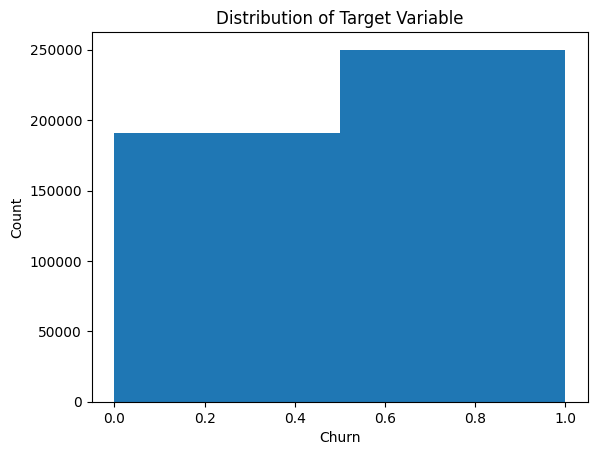

In [ ]:
# Plot the distribution of target variable
plt.hist(dataset['Churn'], bins=2)
plt.title("Distribution of Target Variable")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

* A binary target variable
* No significant class imbalance

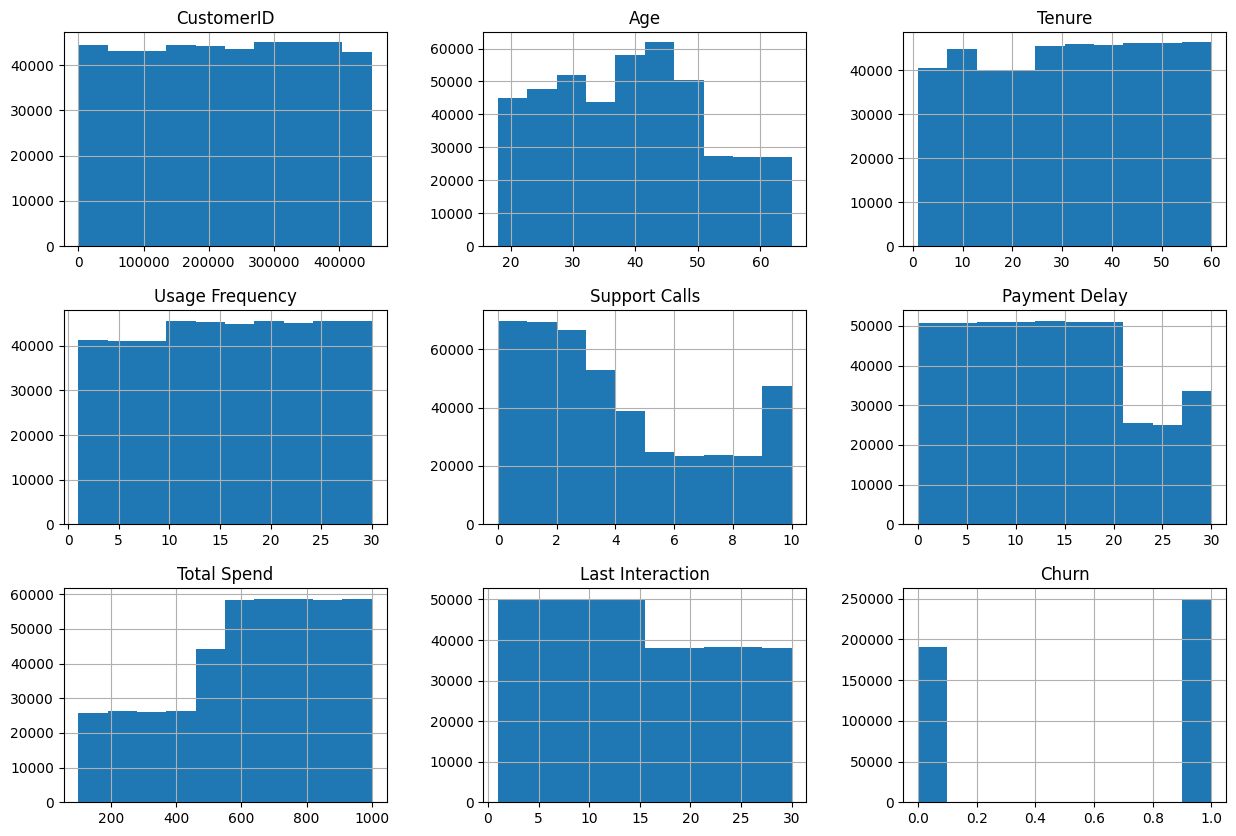

In [ ]:
# Plot histograms for the features
dataset.hist(figsize=(15,10))
plt.show()

* Distributions look normal and no signifiant peaks or outliers

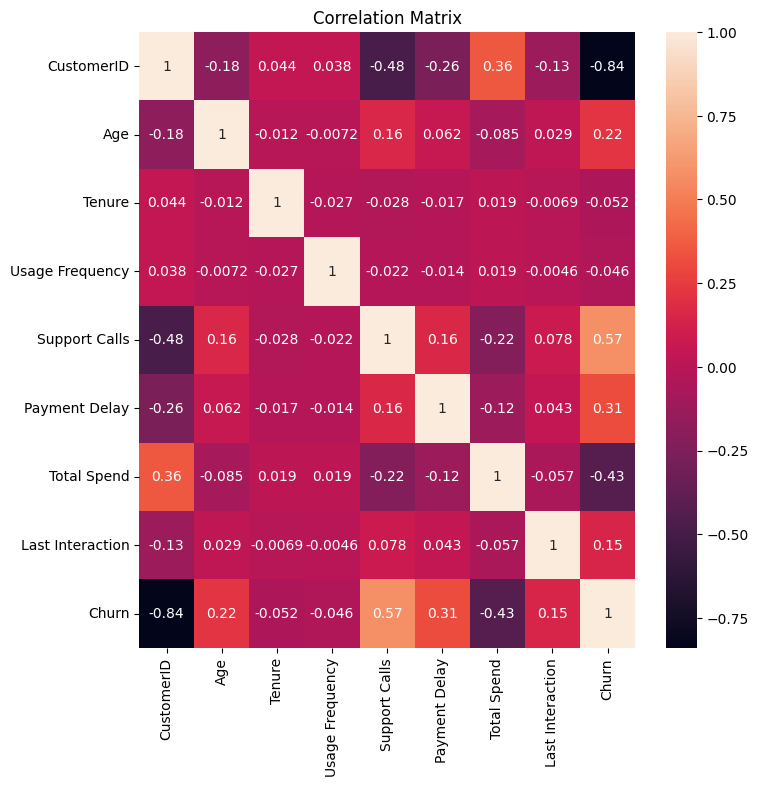

In [ ]:
# Check the correlation with a heatmap

corr = dataset.corr(numeric_only=True)
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True)
plt.title("Correlation Matrix")
plt.show()

* No significant correlations / No multicollinearity

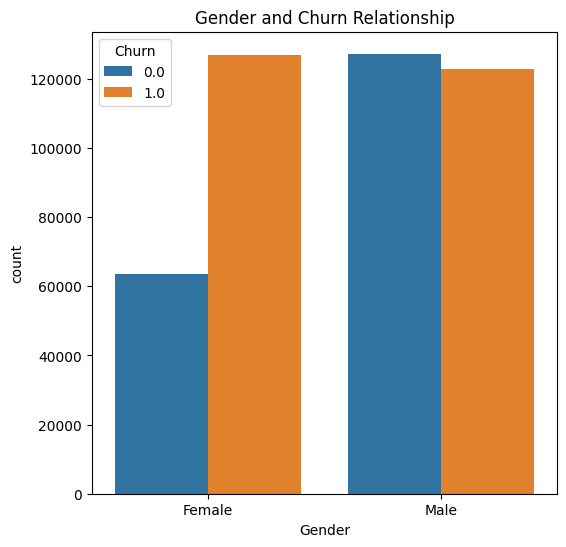

In [ ]:
# Gender and Churn Relationship
plt.figure(figsize=(6,6))
sns.countplot(x='Gender', hue='Churn', data=dataset)
plt.title("Gender and Churn Relationship")
plt.show()

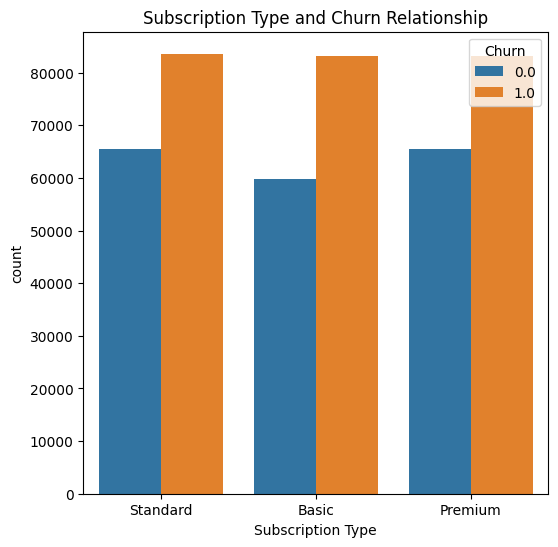

In [ ]:
# Subscription Type and Churn Relationship
plt.figure(figsize=(6,6))
sns.countplot(x='Subscription Type', hue='Churn', data=dataset)
plt.title("Subscription Type and Churn Relationship")
plt.show()

# Data Preprocessing

In [ ]:
# Remove CustomerID - Does not add any value
dataset.drop(['CustomerID'], axis=1, inplace=True)

In [ ]:
# Check for missing values
dataset.isnull().sum()

,0
Age,18
Gender,89
Tenure,18
Usage Frequency,68
Support Calls,96
Payment Delay,79
Subscription Type,61
Contract Length,59
Total Spend,8
Last Interaction,57


* Remove the null Churn, since it cannot add any value

In [ ]:
dataset.dropna(subset=['Churn'], inplace=True)

In [ ]:
# Check the percentage of missing values
missing_percentage = dataset.isnull().sum()/len(dataset)*100

missing_percentage

,0
Age,0.003856
Gender,0.019962
Tenure,0.003856
Usage Frequency,0.015199
Support Calls,0.021550
Payment Delay,0.017694
Subscription Type,0.013611
Contract Length,0.013157
Total Spend,0.001588
Last Interaction,0.012703


* Missing values represent only a small percentage
* But still could represent valuable data

In [ ]:
# Encode Categorical variables

# Identify the categorical columns and their unique values
categorical_cols = [col for col in dataset.columns if dataset[col].dtype == 'object']

for col in categorical_cols:
  uniques = dataset[col].unique()
  print(f"{col}: {uniques}")

Gender: ['Female' 'Male' nan]
Subscription Type: ['Standard' 'Basic' 'Premium' nan]
Contract Length: ['Annual' 'Monthly' 'Quarterly' nan]


In [ ]:
dataset['Gender'] = dataset['Gender'].map({'Male':1, 'Female':0})
dataset['Subscription Type'] = dataset['Subscription Type'].map({'Basic':0, 'Standard':1, 'Premium':2})
dataset['Contract Length'] = dataset['Contract Length'].map({'Monthly': 0, 'Quarterly': 1, 'Yearly': 2})

In [ ]:
# Mean and Mode Imputation

# For Numerical columns
def mean_impute(dataset, column):
  dataset[column] = dataset[column].fillna(dataset[column].mean())

#For Categorical columns
def mode_impute(dataset, column):
  dataset[column] = dataset[column].fillna(dataset[column].mode()[0])


In [ ]:
numerical_cols_to_impute = ['Age', 'Tenure', 'Support Calls', 'Payment Delay', 'Last Interaction']
categorical_cols_to_impute = ['Gender', 'Subscription Type', 'Contract Length']

for col in numerical_cols_to_impute:
  mean_impute(dataset, col)

for col in categorical_cols_to_impute:
  mode_impute(dataset, col)

In [ ]:
# Impute with KNN Imputer
from sklearn.impute import KNNImputer

# initiate the model
N_NEIGHBORS = 3

knn = KNNImputer(n_neighbors=N_NEIGHBORS)

dataset_temp = dataset[['Usage Frequency', 'Total Spend']]

# fit and transform the data
dataset_imputed = knn.fit_transform(dataset_temp)

# convert to dataframe and add to original dataset
dataset[['Usage Frequency', 'Total Spend']] = pd.DataFrame(dataset_imputed, columns=['Usage Frequency', 'Total Spend'], index=dataset.index)

In [ ]:
dataset.isnull().any()

,0
Age,False
Gender,False
Tenure,False
Usage Frequency,False
Support Calls,False
Payment Delay,False
Subscription Type,False
Contract Length,False
Total Spend,False
Last Interaction,False


In [ ]:
dataset.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,0.0,39.0,14.0,5.0,18.0,1.0,1.0,932.0,17.0,1.0
1,65.0,0.0,49.0,1.0,10.0,8.0,0.0,0.0,557.0,6.0,1.0
2,55.0,0.0,14.0,4.0,6.0,18.0,0.0,1.0,185.0,3.0,1.0
3,58.0,1.0,38.0,21.0,7.0,7.0,1.0,0.0,396.0,29.0,1.0
4,23.0,1.0,32.0,20.0,5.0,8.0,0.0,0.0,617.0,20.0,1.0


In [ ]:
# Scaling
dataset.describe()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.372905,0.567756,31.256491,15.807303,3.604544,12.965545,1.012823,0.802424,631.614020,14.481020,0.567107
std,12.442066,0.495388,17.255355,8.585819,3.069954,8.257299,0.813308,0.398171,240.800344,8.595676,0.495477
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,0.000000,16.000000,9.000000,1.000000,6.000000,0.000000,1.000000,480.000000,7.000000,0.000000
50%,39.000000,1.000000,32.000000,16.000000,3.000000,12.000000,1.000000,1.000000,661.000000,14.000000,1.000000
75%,48.000000,1.000000,46.000000,23.000000,6.000000,19.000000,2.000000,1.000000,830.000000,22.000000,1.000000
max,65.000000,1.000000,60.000000,30.000000,10.000000,30.000000,2.000000,1.000000,1000.000000,30.000000,1.000000


In [ ]:
# Check for class imbalance
dataset['Churn'].value_counts()

,count
Churn,
1.0,249999
0.0,190833


In [ ]:
# SPecify Target and Features
X = dataset.drop(columns=['Churn'], axis=1)
y = dataset['Churn']

In [ ]:
X

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
0,30.0,0.0,39.0,14.0,5.0,18.0,1.0,1.0,932.00,17.0
1,65.0,0.0,49.0,1.0,10.0,8.0,0.0,0.0,557.00,6.0
2,55.0,0.0,14.0,4.0,6.0,18.0,0.0,1.0,185.00,3.0
3,58.0,1.0,38.0,21.0,7.0,7.0,1.0,0.0,396.00,29.0
4,23.0,1.0,32.0,20.0,5.0,8.0,0.0,0.0,617.00,20.0
...,...,...,...,...,...,...,...,...,...,...
440828,42.0,1.0,54.0,15.0,1.0,3.0,2.0,1.0,716.38,8.0
440829,25.0,0.0,8.0,13.0,1.0,20.0,2.0,1.0,745.38,2.0
440830,26.0,1.0,35.0,27.0,1.0,5.0,1.0,1.0,977.31,9.0
440831,28.0,1.0,55.0,14.0,2.0,0.0,1.0,1.0,602.55,2.0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Transform back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Feature Engineering

In [ ]:
# Feature Selection - using Random Forest

from sklearn.ensemble import RandomForestRegressor

#Initiate a model
rf = RandomForestRegressor(random_state=42)

# Train the model
rf.fit(X_scaled, y)

RandomForestRegressor(random_state=42)

In [ ]:
# Get Feature importances
feature_imp_df = pd.DataFrame({'Feature':X.columns, 'Importance':rf.feature_importances_})
feature_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

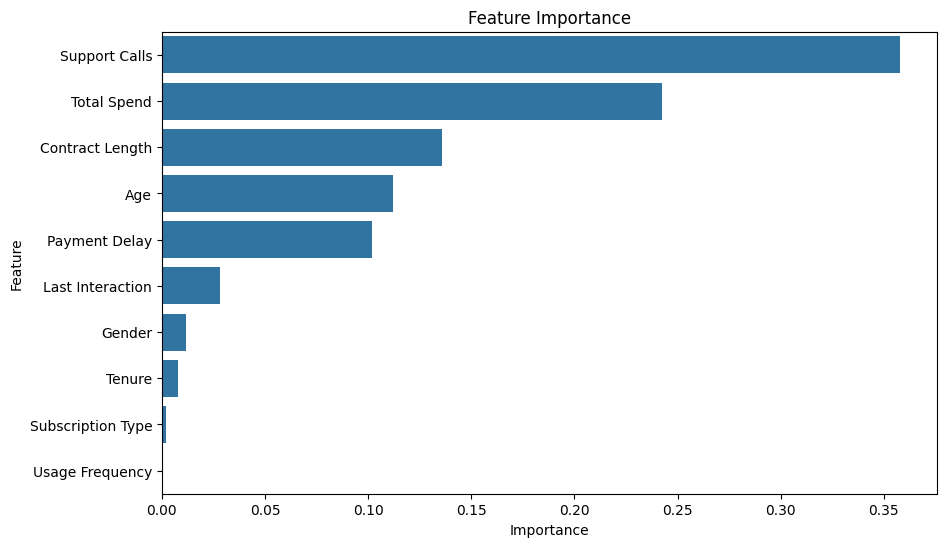

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df)
plt.title('Feature Importance')
plt.show()

* Retain only features above 0.05

In [ ]:
X_scaled.drop(columns=['Last Interaction', 'Gender', 'Tenure', 'Subscription Type', 'Usage Frequency'], axis=1, inplace=True)

In [ ]:
# Create New Features

#Specify Customers according to usage
dataset['Usage Frequency'].describe()

,Usage Frequency
count,440832.000000
mean,15.807303
std,8.585819
min,1.000000
25%,9.000000
50%,16.000000
75%,23.000000
max,30.000000


In [ ]:
# Based on the quartiles
bins = [0,9,16,23,30]
types = ['Low Usage', 'Moderate Usage', 'High Usage', 'Very High Usage']
X_scaled['Customer_Type'] =  pd.cut(dataset['Usage Frequency'], bins=bins, labels=types)

In [ ]:
X_scaled['Customer_Type'].value_counts()

,count
Customer_Type,
Low Usage,123324
Very High Usage,106044
Moderate Usage,105783
High Usage,105681


In [ ]:
# Encode new column - OneHOt Encoding

X_encoded = pd.get_dummies(X_scaled, columns=['Customer_Type'])
X_encoded.head()

,Age,Support Calls,Payment Delay,Contract Length,Total Spend,Customer_Type_Low Usage,Customer_Type_Moderate Usage,Customer_Type_High Usage,Customer_Type_Very High Usage
0,-0.753325,0.454553,0.609698,0.496210,1.247450,False,True,False,False
1,2.059716,2.083244,-0.601353,-2.015275,-0.309859,True,False,False,False
2,1.255990,0.780291,0.609698,0.496210,-1.854709,True,False,False,False
3,1.497108,1.106030,-0.722458,-2.015275,-0.978463,False,False,True,False
4,-1.315933,0.454553,-0.601353,-2.015275,-0.060689,False,False,True,False


In [ ]:
# Convert the bool to numeric
boolean_columns = [col for col in X_encoded.columns if X_encoded[col].dtype == 'bool']

X_encoded[boolean_columns] = X_encoded[boolean_columns].astype(int)
X_encoded.head()

,Age,Support Calls,Payment Delay,Contract Length,Total Spend,Customer_Type_Low Usage,Customer_Type_Moderate Usage,Customer_Type_High Usage,Customer_Type_Very High Usage
0,-0.753325,0.454553,0.609698,0.496210,1.247450,0,1,0,0
1,2.059716,2.083244,-0.601353,-2.015275,-0.309859,1,0,0,0
2,1.255990,0.780291,0.609698,0.496210,-1.854709,1,0,0,0
3,1.497108,1.106030,-0.722458,-2.015275,-0.978463,0,0,1,0
4,-1.315933,0.454553,-0.601353,-2.015275,-0.060689,0,0,1,0


# Modeling

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
# Initiate MOdels

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

lr_model = LogisticRegression()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

In [ ]:
# Train the Models and Predict

def train_predict_model(model, X_train, y_train, X_test):
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)
  return prediction

In [ ]:
lr_pred = train_predict_model(lr_model, X_train, y_train, X_test)
dt_pred = train_predict_model(dt_model, X_train, y_train, X_test)
rf_pred = train_predict_model(rf_model, X_train, y_train, X_test)

# Evaluation

In [ ]:
# Evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def evaluate_model(model, model_name, X_test, y_test, prediction):
  accuracy = round(model.score(X_test, y_test),2)*100
  cm = confusion_matrix(y_test, prediction)
  cr = classification_report(y_test, prediction)

  print(f"{model_name} Accuracy: {accuracy}%")
  print("\n")
  print(f"Classification Report of {model_name}\n{cr}")
  print("\n")
  plt.figure(figsize=(6,6))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title(f"Confussion Matrix of {model_name}")
  plt.show()


Logistic Regression Accuracy: 89.0%


Classification Report of Logistic Regression
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.88     38063
         1.0       0.92      0.88      0.90     50104

    accuracy                           0.89     88167
   macro avg       0.89      0.89      0.89     88167
weighted avg       0.89      0.89      0.89     88167





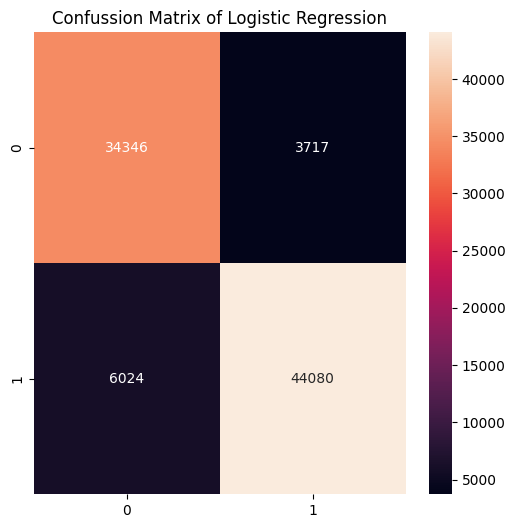

In [ ]:
# Evaluate the models
evaluate_model(lr_model, 'Logistic Regression', X_test, y_test, lr_pred)

Decision Tree Accuracy: 98.0%


Classification Report of Decision Tree
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     38063
         1.0       0.98      0.98      0.98     50104

    accuracy                           0.98     88167
   macro avg       0.98      0.98      0.98     88167
weighted avg       0.98      0.98      0.98     88167





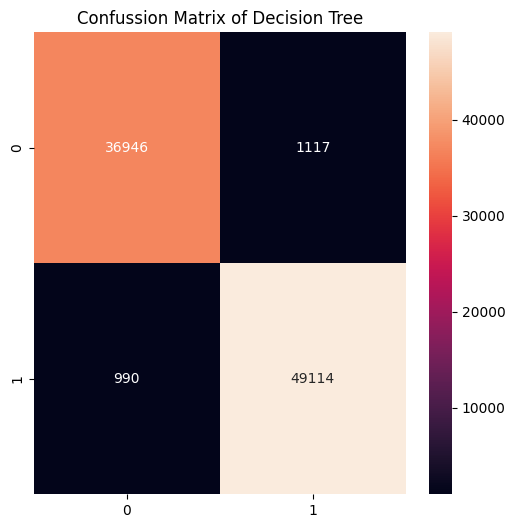

In [ ]:
evaluate_model(dt_model, 'Decision Tree', X_test, y_test, dt_pred)

Random Forest Accuracy: 99.0%


Classification Report of Random Forest
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     38063
         1.0       1.00      0.98      0.99     50104

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167





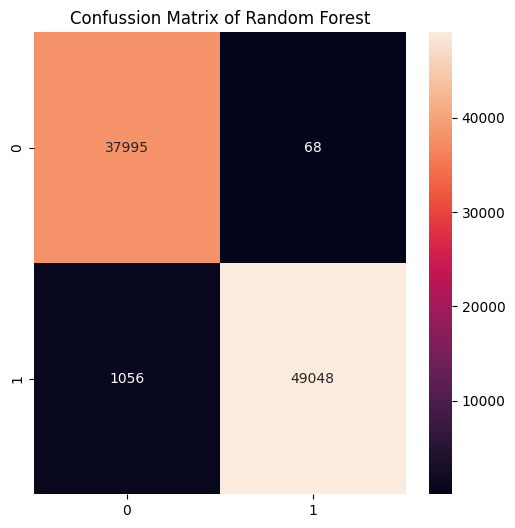

In [ ]:
evaluate_model(rf_model, 'Random Forest', X_test, y_test, rf_pred)

* Decision Tree and Random Forest showed the best performances
* Since it is 99%, hyperparameter tuning will not be needed